Resources to take a look to improve performance:

https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# Description

In this competition we are asked to predict taxi ride fare based upon picup datetime, pickup coordinates and dropoff coordinates.

In this example I used XGBoost as it is proven to be very successful in such kind of problems. 

I will augment data using features like isgroup (more than 3 persons ride), from or to airport (based on the intuition it can be an important factor). 

Once again, because of environment restrictions, I won't be using all the data available.

In [1]:
import numpy as np 
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os

print(os.listdir("."))


['.config', 'sample_data']


In [0]:
import os

os.makedirs('./data/')

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    



In [0]:
import sys

#https://drive.google.com/open?id=XXXXXXXXXXXXXXXX
# TAKE ID FROM SHAREABLE LINK
file_id_train = 'XXXXXXXXXXXXXXXXXXX'
# DESTINATION FILE ON YOUR DISK
destination_train = './data/train.zip'

# Usage: python google_drive.py drive_file_id destination_file_path
download_file_from_google_drive(file_id_train, destination_train)

In [0]:
# test set
#https://drive.google.com/open?id=XXXXXXXXXXXXXXXXXX
# TAKE ID FROM SHAREABLE LINK
file_id_test = 'XXXXXXXXXXXXXXXXXXXXX'
# DESTINATION FILE ON YOUR DISK
destination_test = './data/test.csv'

download_file_from_google_drive(file_id_test, destination_test)

In [0]:
# Unzip

import zipfile

zip_ref = zipfile.ZipFile('./data/train.zip', 'r')
zip_ref.extractall('./data')
zip_ref.close()

In [7]:
!head -10 ./data/train.csv

In [8]:
!head -10 ./data/test.csv

# Read training csv

As there are a lot of training examples, we will limit to just few millions so it can fit in memory. A good approach would be to use spark, dask or other frameworks for streaming that huge amount of data (in total 55GB).

In [9]:
train_df =  pd.read_csv('./data/train.csv', nrows = 1000000) #1M to test models
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [10]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
!awk 'FNR > 0 && FNR <= 11000000' ./data/train.csv > ./data/train_awk_1.csv
!echo "File 1 created"

!awk 'FNR > 11000000 && FNR <= 22000000' ./data/train.csv > ./data/train_awk_2.csv
!sed -i '1s/^/key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count\n/' ./data/train_awk_2.csv
!echo "File 2 created"

!awk 'FNR > 22000000 && FNR <= 33000000' ./data/train.csv > ./data/train_awk_3.csv
!sed -i '1s/^/key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count\n/' ./data/train_awk_3.csv
!echo "File 3 created"

!awk 'FNR > 33000000 && FNR <= 44000000' ./data/train.csv > ./data/train_awk_4.csv
!sed -i '1s/^/key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count\n/' ./data/train_awk_4.csv
!echo "File 4 created"

!awk 'FNR > 44000000 && FNR <= 55000000' ./data/train.csv > ./data/train_awk_5.csv
!sed -i '1s/^/key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count\n/' ./data/train_awk_5.csv
!echo "File 5 created"
!echo "Finished"

File 1 created
File 2 created
File 3 created
File 4 created
File 5 created
Finished


In [12]:
# let's see if the file is ok...
!head -3 ./data/train_awk_3.csv
!wc -l ./data/train_awk_3.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count

2014-01-31 20:18:39.0000003,12.5,2014-01-31 20:18:39 UTC,-73.989302,40.773426,-74.007052,40.735016,2
11000001 ./data/train_awk_3.csv


In [13]:
!ls -la ./data/

total 12720856
drwxr-xr-x 2 root root       4096 Aug 31 06:17 .
drwxr-xr-x 1 root root       4096 Aug 31 06:10 ..
-rw-r--r-- 1 root root     983020 Aug 31 06:10 test.csv
-rw-r--r-- 1 root root 1130766121 Aug 31 06:13 train_awk_1.csv
-rw-r--r-- 1 root root 1130710197 Aug 31 06:14 train_awk_2.csv
-rw-r--r-- 1 root root 1130736759 Aug 31 06:15 train_awk_3.csv
-rw-r--r-- 1 root root 1130703261 Aug 31 06:16 train_awk_4.csv
-rw-r--r-- 1 root root 1130679632 Aug 31 06:17 train_awk_5.csv
-rw-r--r-- 1 root root 5697178298 Aug 31 06:11 train.csv
-rw-r--r-- 1 root root 1674351600 Aug 31 06:10 train.zip


In [14]:
import random

train_files = ["./data/train_awk_1.csv", "./data/train_awk_2.csv", "./data/train_awk_3.csv", "./data/train_awk_4.csv", "./data/train_awk_5.csv"]
datasets = []

NUMBER_OF_RECORDS = 11000000
ROWS_TO_SKIP = 10000000

for file in train_files :
  print("Working on "+file)
  print ("getting the rows to skip...")
  skip = sorted (random.sample (range(1, NUMBER_OF_RECORDS),ROWS_TO_SKIP))
  print ("reading file and creating dataset...")
  tmp_df = pd.read_csv (file, skiprows=skip)
  datasets.append(tmp_df)
  print ("dataset appended")
  
print ("merging datasets...")
train_df = pd.concat(datasets)
print ("finished")
print (str(len(train_df)) + " rows")
train_df.tail()

Working on ./data/train_awk_1.csv
getting the rows to skip...
reading file and creating dataset...
dataset appended
Working on ./data/train_awk_2.csv
getting the rows to skip...
reading file and creating dataset...
dataset appended
Working on ./data/train_awk_3.csv
getting the rows to skip...
reading file and creating dataset...
dataset appended
Working on ./data/train_awk_4.csv
getting the rows to skip...
reading file and creating dataset...
dataset appended
Working on ./data/train_awk_5.csv
getting the rows to skip...
reading file and creating dataset...
dataset appended
merging datasets...
finished
4999999 rows


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
999995,2012-03-07 23:03:38.0000003,12.10,2012-03-07 23:03:38 UTC,-73.994937,40.739717,-73.971837,40.791865,1
999996,2015-03-24 22:36:55.0000006,13.54,2015-03-24 22:36:55 UTC,-73.975807,40.749378,-73.957764,40.742741,1
999997,2012-02-01 07:42:00.000000125,18.90,2012-02-01 07:42:00 UTC,-74.017390,40.708000,-73.979203,40.764942,1
999998,2009-12-06 10:31:08.0000001,4.50,2009-12-06 10:31:08 UTC,-73.736054,40.731822,-73.736054,40.731822,1
999999,2015-02-14 15:11:33.0000002,7.50,2015-02-14 15:11:33 UTC,-73.996964,40.752453,-74.005409,40.742172,2


In [15]:
cols = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
train_df = train_df.reindex (cols, axis=1)
print (len(train_df))

4999999


In [16]:
train_df.tail()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
999995,2012-03-07 23:03:38.0000003,12.10,2012-03-07 23:03:38 UTC,-73.994937,40.739717,-73.971837,40.791865,1
999996,2015-03-24 22:36:55.0000006,13.54,2015-03-24 22:36:55 UTC,-73.975807,40.749378,-73.957764,40.742741,1
999997,2012-02-01 07:42:00.000000125,18.90,2012-02-01 07:42:00 UTC,-74.017390,40.708000,-73.979203,40.764942,1
999998,2009-12-06 10:31:08.0000001,4.50,2009-12-06 10:31:08 UTC,-73.736054,40.731822,-73.736054,40.731822,1
999999,2015-02-14 15:11:33.0000002,7.50,2015-02-14 15:11:33 UTC,-73.996964,40.752453,-74.005409,40.742172,2


We now have our training file based on random examples from the whole training set. Again, a better solution using frameworks for dealing with such amount of data shoud be used. For playing around this will be just fine.

# Visualization

Some visualization...

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


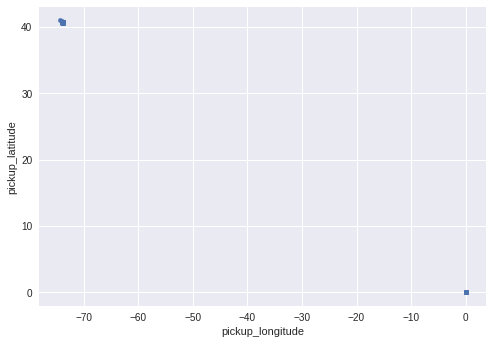

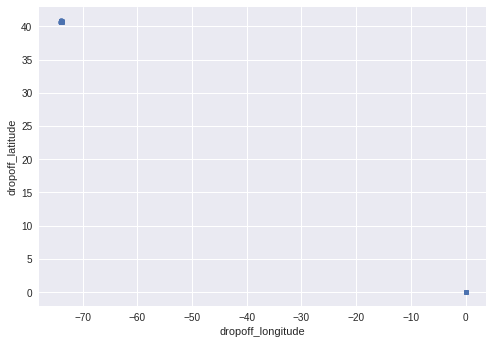

In [5]:
#Plot variables using only 1000 rows for efficiency
train_df.iloc[:1000].plot.scatter('pickup_longitude', 'pickup_latitude')
train_df.iloc[:1000].plot.scatter('dropoff_longitude', 'dropoff_latitude')

#Get distribution of values
train_df.describe()

# Preparing dataset

We now have the dataset. We have to clean it a bit and add a few features that can help the model.

In [17]:
#Clean dataset
def clean_df(df):
    #Drop rows with null values
    df = df.drop('key', axis = 1)
    df = df.dropna()

    return df[(df.fare_amount > 1) & (df.fare_amount < 300) &
            (df.pickup_longitude > -78) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -78) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 37) & (df.dropoff_latitude < 45) &
            (df.passenger_count > 0)]

train_df = clean_df(train_df)
print(len(train_df))

4878305


In [18]:
print(train_df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Creation of the 'from_to_airport' feature based on the intuition that could be useful because of special fares for those rides. To be analyzed using visualization for example...

We'll also create the 'is_group_trip', but the model should figure that by itself based on the training data...

Finally, 'distance' feature can be very useful.

In [0]:
import numpy as np

def from_to_JFK (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    return (((pickup_lat > 40.62) & (pickup_lat < 40.66) & (pickup_lon > -73.83) & (pickup_lon < -73.75)) |
            ((dropoff_lat > 40.62) & (dropoff_lat < 40.66) & (dropoff_lon > -73.83) & (dropoff_lon < -73.75)))

def from_to_EWR (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    return (((pickup_lat > 40.67) & (pickup_lat < 40.70) & (pickup_lon > -74.15) & (pickup_lon < -74.195)) | 
            ((dropoff_lat > 40.67) & (dropoff_lat < 40.70) & (dropoff_lon > -74.15) & (dropoff_lon < -74.195)))

def from_to_LGA (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    return (((pickup_lat > 40.77) & (pickup_lat < 40.775) & (pickup_lon > -73.853) & (pickup_lon < -73.888)) | 
            ((dropoff_lat > 40.77) & (dropoff_lat < 40.775) & (dropoff_lon > -73.853) & (dropoff_lon < -73.888)))

def from_to_airport (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    return (from_to_JFK (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon) |
             (from_to_EWR (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)) |
             (from_to_LGA (pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)))

def add_from_to_airport (dataset):
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    dataset['from_to_airport'] = from_to_airport(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon) 
    return dataset

def euclidear_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    latdiff = pickup_lat - dropoff_lat
    londiff = pickup_lon - dropoff_lon
    return np.sqrt(latdiff * latdiff + londiff * londiff)

def add_euclidear_dist (dataset):
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    dataset['euclidear_dist'] = euclidear_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon) 
    return dataset
  
def is_group_trip (n_passengers):
    return (n_passengers > 4)
  
def add_is_group (dataset):
    n_passengers = dataset['passenger_count']
    dataset['is_group'] = is_group_trip (n_passengers) 
    return dataset

In [0]:
train_df = add_euclidear_dist(train_df)
train_df = add_from_to_airport(train_df)
train_df = add_is_group (train_df)

In [0]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    dataset['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset
    
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    dataset = dataset.drop('pickup_datetime', axis = 1)
    
    return dataset



In [22]:
train_df = add_datetime_info(train_df)
#train_df = add_airport_dist(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidear_dist,from_to_airport,is_group,hour,day,month,weekday,year,distance
0,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,False,False,0,18,8,3,2011,1.389525
1,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,False,False,4,21,4,5,2012,2.799270
2,16.5,-73.951300,40.774138,-73.990095,40.751048,1,0.045146,False,False,17,4,1,2,2012,4.155444
3,5.3,-73.981060,40.737690,-73.994177,40.728412,1,0.016067,False,False,16,22,7,2,2009,1.511904
4,4.5,-73.981020,40.737760,-73.980668,40.730497,2,0.007272,False,False,0,11,8,6,2013,0.808153


In [0]:
#Clean dataset
def clean_df_distances(df):
    return df[(df.euclidear_dist > 0.0) & (df.distance > 0.0)]

train_df = clean_df_distances(train_df)
print(len(train_df))

In [0]:
#final train_df
train_df.head()

# Preparing training

Using a prebuilt function we get the training and validation split.

In [0]:
y = train_df['fare_amount']
train = train_df.drop(columns=['fare_amount'])

x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=0,test_size=0.01)

In [24]:
print ("Train shape: {0}".format(x_train.shape))
print ("Test shape: {0}".format(x_test.shape))

Train shape: (4829521, 14)
Test shape: (48784, 14)


# Find out hyperparameters

In [0]:
target = 'fare_amount'
IDcol = 'key'

In [31]:
x_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'euclidear_dist',
       'from_to_airport', 'is_group', 'hour', 'day', 'month', 'weekday',
       'year', 'distance'],
      dtype='object')

In [0]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {0}".format (metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)))
    print ("AUC Score (Train): {0}".format (metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [0]:
from xgboost.sklearn import XGBClassifier

#Choose all predictors except target & IDcols
#predictors = [x for x in x_train.columns if x not in [target, IDcol]]
predictors = x_train.columns
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors)

In [25]:
# Original version


#Cross-validation
params = {
    # Parameters that we are going to tune.
    'max_depth': 8, #Result of tuning with CV
    'eta':.015, #Result of tuning with CV
    'subsample': 1.0, #Result of tuning with CV
    'colsample_bytree': 0.6, #Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1
}

#Block of code used for hypertuning parameters. Adapt to each round of parameter tuning.
#Turn off CV in submission
CV=False
if CV:
    dtrain = xgb.DMatrix(train,label=y)
    gridsearch_params = [
        (eta)
        for eta in np.arange(.04, 0.12, .02)
    ]

    # Define initial best params and RMSE
    min_rmse = float("Inf")
    best_params = None
    for (eta) in gridsearch_params:
        print("CV with eta={} ".format(eta))

        # Update our parameters
        params['eta'] = eta

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=3,
            metrics={'rmse'},
            early_stopping_rounds=10
        )

        # Update best RMSE
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (eta)

    print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
else:
    #Print final params to use for the model
    params['silent'] = 0 #Turn on output
    print(params)

{'max_depth': 8, 'eta': 0.015, 'subsample': 1.0, 'colsample_bytree': 0.6, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 0}


# Run the model

In [26]:
def XGBmodel(x_train,x_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=1500, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(x_train,x_test,y_train,y_test,params)

[0]	test-rmse:14.4793
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:14.2827
[2]	test-rmse:14.0926
[3]	test-rmse:13.9127
[4]	test-rmse:13.7286
[5]	test-rmse:13.545
[6]	test-rmse:13.3649
[7]	test-rmse:13.1873
[8]	test-rmse:13.013
[9]	test-rmse:12.8408
[10]	test-rmse:12.6739
[11]	test-rmse:12.5076
[12]	test-rmse:12.3448
[13]	test-rmse:12.1842
[14]	test-rmse:12.0289
[15]	test-rmse:11.8748
[16]	test-rmse:11.7219
[17]	test-rmse:11.5726
[18]	test-rmse:11.4393
[19]	test-rmse:11.3099
[20]	test-rmse:11.1659
[21]	test-rmse:11.0252
[22]	test-rmse:10.8876
[23]	test-rmse:10.7512
[24]	test-rmse:10.616
[25]	test-rmse:10.4844
[26]	test-rmse:10.367
[27]	test-rmse:10.2405
[28]	test-rmse:10.1164
[29]	test-rmse:10.0058
[30]	test-rmse:9.90903
[31]	test-rmse:9.79065
[32]	test-rmse:9.67351
[33]	test-rmse:9.55932
[34]	test-rmse:9.44664
[35]	test-rmse:9.33435
[36]	test-rmse:9.23771
[37]	test-rmse:9.13068
[38]	test-rmse:9.02556
[39]	test-rmse:8.91971
[40]	test-rmse:8.81708
[41]	test-rmse

# Submision

In [0]:
#Read and preprocess test set
test_df =  pd.read_csv('./data/test.csv')

test_df = add_euclidear_dist(test_df)
test_df = add_from_to_airport(test_df)
test_df = add_is_group (test_df)
test_df = add_datetime_info(test_df)
#test_df = add_airport_dist(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df.head()

test_key = test_df['key']
x_pred = test_df.drop(columns=['key'])

#Predict from test set
prediction = model.predict(xgb.DMatrix(x_pred), ntree_limit = model.best_ntree_limit)

In [0]:
!mkdir tmp

In [28]:
#Create submission file
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.round(2)
})

submission.to_csv('./data/taxi_fare_submission.csv',index=False)
submission.head()

,fare_amount,key
0,10.21,2015-01-27 13:08:24.0000002
1,10.25,2015-01-27 13:08:24.0000003
2,4.52,2011-10-08 11:53:44.0000002
3,8.99,2012-12-01 21:12:12.0000002
4,15.50,2012-12-01 21:12:12.0000003


In [20]:
!head -10 ./data/taxi_fare_submission.csv

fare_amount,key
9.76,2015-01-27 13:08:24.0000002
10.04,2015-01-27 13:08:24.0000003
4.38,2011-10-08 11:53:44.0000002
9.45,2012-12-01 21:12:12.0000002
16.33,2012-12-01 21:12:12.0000003
10.47,2012-12-01 21:12:12.0000005
5.36,2011-10-06 12:10:20.0000001
49.47,2011-10-06 12:10:20.0000003
11.91,2011-10-06 12:10:20.0000002
